# Gene Set Enrichment Analysis (GSEA)
# Phase 2 vs. Phase 2

uses an entire ranked list (by log2FoldChange) of genes to see if pathway genes cluster at the top or bottom

#### Are *pathways* generally over- or under-expressed in a given treatment?

This method is somewhat preferred over over-representation analysis (ORA)

using [clusterProfiler](https://github.com/YuLab-SMU/clusterProfiler) R package


## 0. load libraries

In [2]:
library(tidyverse)
library(clusterProfiler) # for GSEA()
library(enrichplot) # for enrichment visuals
library(GO.db) # for gene ontology database
library(UpSetR) # for Cvirginica annotations
library(patchwork) # for arranging multiple plots

## 1. read in CSVs

read in GO annotation data

In [4]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [5]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [6]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


read in *all* genes from DESeq output (not just DEGs)

In [7]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes',
    pattern = '\\.csv$',
    full.names = TRUE
    )

head(files)

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv"
[2] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_bb.csv"
[3] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cc.csv"
[4] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_hc.csv"
[5] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_wc.csv"
[6] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_ch.csv"

In [8]:
names(files) <- tools::file_path_sans_ext(basename(files))
df_list <- lapply(files, read.csv)
names(df_list)
length(df_list)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

[1] 35

## 2. Formatting CSVs
input to `gsea()` is an order ranked geneList - I'm going to rank by log2FoldChange

In [9]:
# create numeric vector, ordered by LFC
all_df <- lapply(df_list, function(df) {
    geneList <- df$log2FoldChange 
    # Set gene IDs as names
    names(geneList) <- df$Gene
    
    # Sort in decreasing order
    geneList <- sort(geneList, decreasing = TRUE)

    return(geneList)
    })

# check things look okay 
head(all_df$bb_cc)

LOC111132404 LOC111103543 LOC111114729 LOC111123832 LOC111113513 LOC111109183 
    27.90214     27.31922     24.33483     23.66240     23.58794     23.21534

## 3. Run GSEA

Output notes [from here](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideTEXT.htm):
- setSize
- enrichmentScore - degree to which the gene set is overrepresented at the top or bottom of a ranked list of genes (pos = top of list, neg = bottom of list)
- NES - normalized enrichment score; should be used to compare analysis results across gene sets
- qvalue - also FDR (false discovery rate)
- rank
- leading_edge - core group of genes that accounts for the gene set's enrichment signal
- core_enrichment - subset of genes that contributes most to the enrichment result

geneRatio - how much of a pathway (gene set) is represented in ranked genes that contribute to the enrichment signal

### 1. effect of single exposure after period of recovery
- CC vs. WC
- CC vs. HC
- CC vs. BC

In [10]:
# CC vs. WC
gsea_res_cc.wc <- GSEA(
    geneList = all_df$wc_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.wc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.68% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,0.9995369,1.447656,9.715565e-08,0.0003475257,0.0003475257,6,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0003779,GO:0003779,actin binding,176,0.9980673,1.303450,4.728881e-07,0.0008457604,0.0008457604,6,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0031252,GO:0031252,cell leading edge,46,0.9995173,1.483281,1.578634e-06,0.0018822578,0.0018822578,6,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0051491,GO:0051491,positive regulation of filopodium assembly,36,0.9994790,1.501058,2.854965e-06,0.0025530524,0.0025530524,6,"tags=3%, list=0%, signal=3%",LOC111109183
GO:0010591,GO:0010591,regulation of lamellipodium assembly,12,0.9997866,1.544224,3.766775e-06,0.0026947507,0.0026947507,6,"tags=8%, list=0%, signal=8%",LOC111109183
GO:0046847,GO:0046847,filopodium assembly,28,0.9993966,1.509919,5.709152e-05,0.0340360637,0.0340360637,6,"tags=4%, list=0%, signal=4%",LOC111109183
GO:0060288,GO:0060288,formation of a compartment boundary,14,0.9994915,1.545110,9.981296e-05,0.0446288698,0.0446288698,6,"tags=7%, list=0%, signal=7%",LOC111109183
GO:0035262,GO:0035262,gonad morphogenesis,10,0.9998048,1.529080,9.287720e-05,0.0446288698,0.0446288698,6,"tags=10%, list=0%, signal=10%",LOC111109183


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


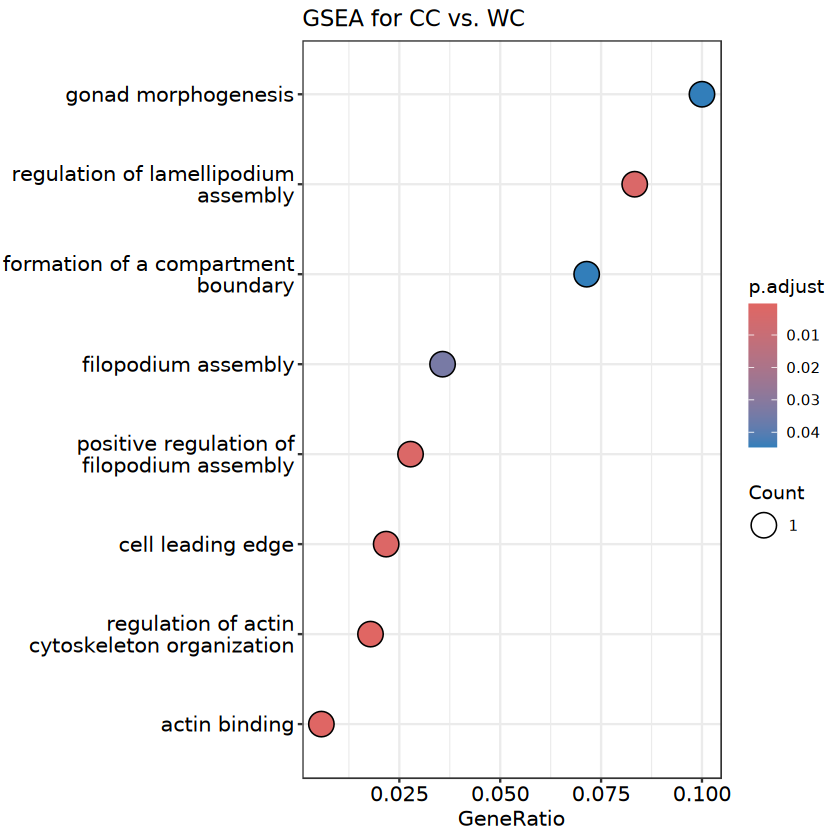

In [11]:
dotplot(gsea_res_cc.wc, showCategory=20) + ggtitle('GSEA for CC vs. WC')

- lamellipodium - primarily found in mobile cells, involved in quick repair of wounds, pulls the cell forward during cell migration
- cell leading edge - area of motile cell closest to direction of movement

so seems we have GO terms enriched for cell movement/motility?

In [12]:
# CC vs. HC
gsea_res_cc.hc <- GSEA(
    geneList = all_df$hc_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.hc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0010591,GO:0010591,regulation of lamellipodium assembly,12,0.9998832,1.615297,5.725099e-08,0.0002047868,0.0002047868,3,"tags=8%, list=0%, signal=8%",LOC111109183
GO:0030027,GO:0030027,lamellipodium,150,0.9987861,1.304316,2.246721e-07,0.0004018260,0.0004018260,3,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0017124,GO:0017124,SH3 domain binding,66,0.9996114,1.402202,5.463522e-07,0.0006514340,0.0006514340,3,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0030335,GO:0030335,positive regulation of cell migration,101,0.9990853,1.346156,2.269663e-06,0.0020296461,0.0020296461,3,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0003779,GO:0003779,actin binding,176,0.9981602,1.289121,3.164243e-06,0.0022636997,0.0022636997,3,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0048813,GO:0048813,dendrite morphogenesis,83,0.9992910,1.372128,1.616209e-05,0.0096353021,0.0096353021,3,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0003382,GO:0003382,epithelial cell morphogenesis,14,0.9996529,1.609672,2.191221e-05,0.0111971389,0.0111971389,3,"tags=7%, list=0%, signal=7%",LOC111109183
GO:0031252,GO:0031252,cell leading edge,46,0.9997068,1.495212,4.082087e-05,0.0182520326,0.0182520326,3,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0000781,GO:0000781,"chromosome, telomeric region",90,-0.9988413,-1.298812,6.708900e-05,0.0266641486,0.0266641486,17,"tags=2%, list=0%, signal=2%",LOC111107528/LOC111125439


kinda same deal as CC vs. WC above - a lot of enriched terms for cell motility (cell leading edge, pos. reg. of cell migration) - also telomeric region and double-strand break repair which could suggest cellular damage

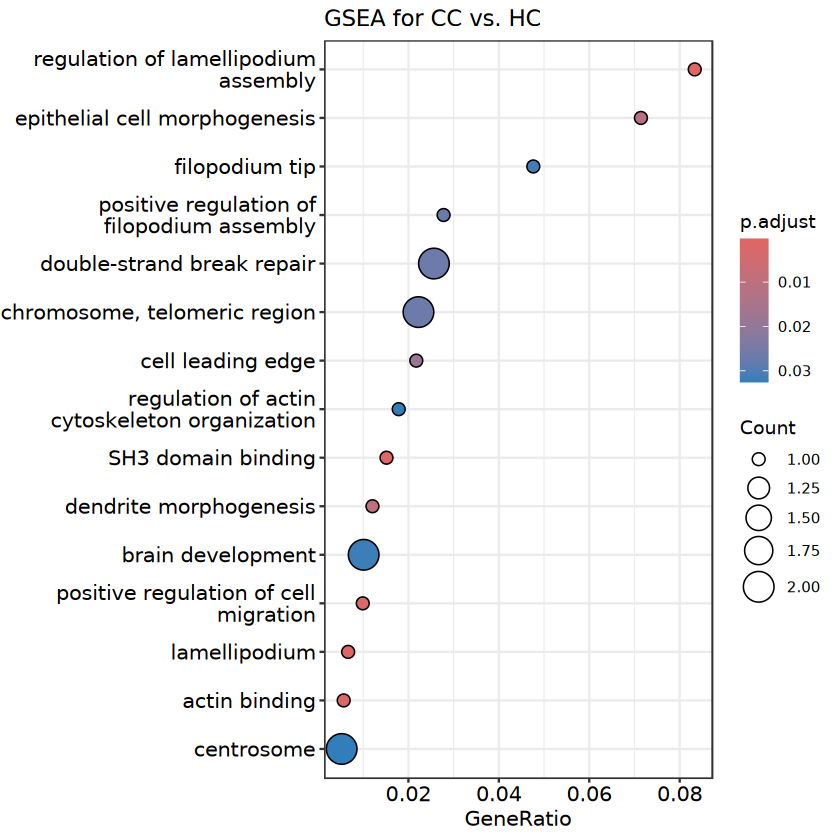

In [13]:
dotplot(gsea_res_cc.hc, showCategory=20) + ggtitle('GSEA for CC vs. HC')

In [14]:
# CC vs. BC
gsea_res_cc.bc <- GSEA(
    geneList = all_df$bc_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.bc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.08% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0003779,GO:0003779,actin binding,176,0.9982430,1.314408,3.591418e-08,9.003433e-05,9.003433e-05,2,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0030027,GO:0030027,lamellipodium,150,0.9987038,1.294731,5.034070e-08,9.003433e-05,9.003433e-05,2,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0051491,GO:0051491,positive regulation of filopodium assembly,36,0.9997417,1.465862,3.800535e-07,4.531505e-04,4.531505e-04,2,"tags=3%, list=0%, signal=3%",LOC111109183
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,0.9993889,1.434077,1.197397e-06,1.070772e-03,1.070772e-03,2,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0030496,GO:0030496,midbody,139,-0.9980189,-1.161493,4.096522e-06,2.930652e-03,2.930652e-03,32,"tags=1%, list=0%, signal=1%",LOC111130294/LOC111103124
GO:0031252,GO:0031252,cell leading edge,46,0.9996681,1.449393,5.639550e-06,3.362112e-03,3.362112e-03,2,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0005815,GO:0005815,microtubule organizing center,96,0.9987635,1.345201,8.242530e-06,4.211933e-03,4.211933e-03,20,"tags=1%, list=0%, signal=1%",LOC111099630
GO:0035262,GO:0035262,gonad morphogenesis,10,0.9998983,1.517357,3.594953e-05,1.428794e-02,1.428794e-02,2,"tags=10%, list=0%, signal=10%",LOC111109183
GO:0043130,GO:0043130,ubiquitin binding,80,0.9986604,1.373574,3.280700e-05,1.428794e-02,1.428794e-02,20,"tags=1%, list=0%, signal=1%",LOC111099630


ubiquitin binding - when ubiquitin is bound, marks the cell for proteolytic degradation

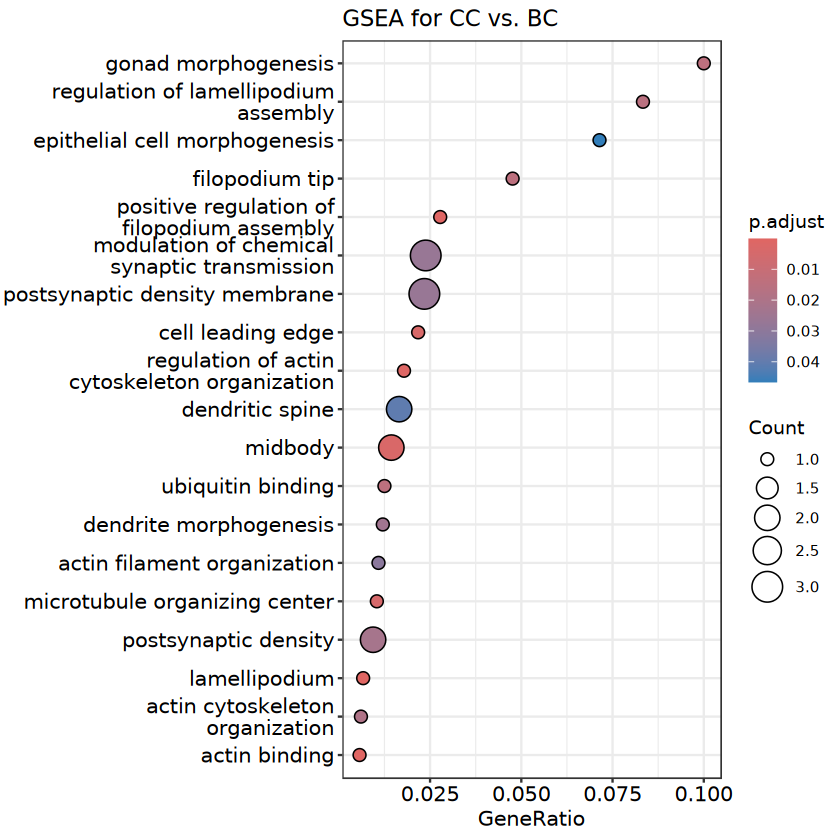

In [15]:
dotplot(gsea_res_cc.bc, showCategory=20) + ggtitle('GSEA for CC vs. BC')

### 2. effect of single late exposure
- CC vs. CW
- CC vs. CH
- CC vs. CB

(no enriched terms for any of these comparisons)

In [32]:
# CC vs. CW
gsea_res_cc.cw <- GSEA(
    geneList = all_df$cw_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.cw)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.96% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [17]:
# CC vs. CH
gsea_res_cc.ch <- GSEA(
    geneList = all_df$ch_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.ch)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.75% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [18]:
# CC vs. CB
gsea_res_cc.cb <- GSEA(
    geneList = all_df$cb_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cc.cb)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.92% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

so all of the comparisons in this group didn't have any enriched GO terms, but when the single stress is early, we have a lot more enriched GO terms ...

### 3. Effect of timing of initial stress exposure
- CW vs. WC (no enriched terms)
- CH vs. HC
- CB vs. BC (no enriched terms)

In [19]:
# CW vs. WC
gsea_res_cw.wc <- GSEA(
    geneList = all_df$cw_wc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cw.wc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.75% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [20]:
# HC vs. CH
gsea_res_ch.hc <- GSEA(
    geneList = all_df$ch_hc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_ch.hc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.47% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0008401,GO:0008401,retinoic acid 4-hydroxylase activity,19,-0.9994642,-1.719069,9.611050e-07,0.003258599,0.003258599,2,"tags=11%, list=0%, signal=11%",LOC111111884/LOC111100601
GO:0042573,GO:0042573,retinoic acid metabolic process,19,-0.9993944,-1.718949,3.414247e-06,0.003258599,0.003258599,2,"tags=11%, list=0%, signal=11%",LOC111111884/LOC111100601
GO:0051345,GO:0051345,positive regulation of hydrolase activity,10,0.9994123,1.679712,6.376905e-06,0.003258599,0.003258599,14,"tags=10%, list=0%, signal=10%",LOC111125439
GO:0061849,GO:0061849,telomeric G-quadruplex DNA binding,10,0.9994123,1.679712,6.376905e-06,0.003258599,0.003258599,14,"tags=10%, list=0%, signal=10%",LOC111125439
GO:0070337,GO:0070337,3'-flap-structured DNA binding,10,0.9994123,1.679712,6.376905e-06,0.003258599,0.003258599,14,"tags=10%, list=0%, signal=10%",LOC111125439
GO:0098530,GO:0098530,positive regulation of strand invasion,10,0.9994123,1.679712,6.376905e-06,0.003258599,0.003258599,14,"tags=10%, list=0%, signal=10%",LOC111125439
GO:1905773,GO:1905773,8-hydroxy-2'-deoxyguanosine DNA binding,10,0.9994123,1.679712,6.376905e-06,0.003258599,0.003258599,14,"tags=10%, list=0%, signal=10%",LOC111125439
GO:0061749,GO:0061749,forked DNA-dependent helicase activity,12,0.9993798,1.693991,1.263435e-05,0.005649135,0.005649135,14,"tags=8%, list=0%, signal=8%",LOC111125439
GO:0032405,GO:0032405,MutLalpha complex binding,11,0.9994094,1.696234,1.453655e-05,0.005777472,0.005777472,14,"tags=9%, list=0%, signal=9%",LOC111125439


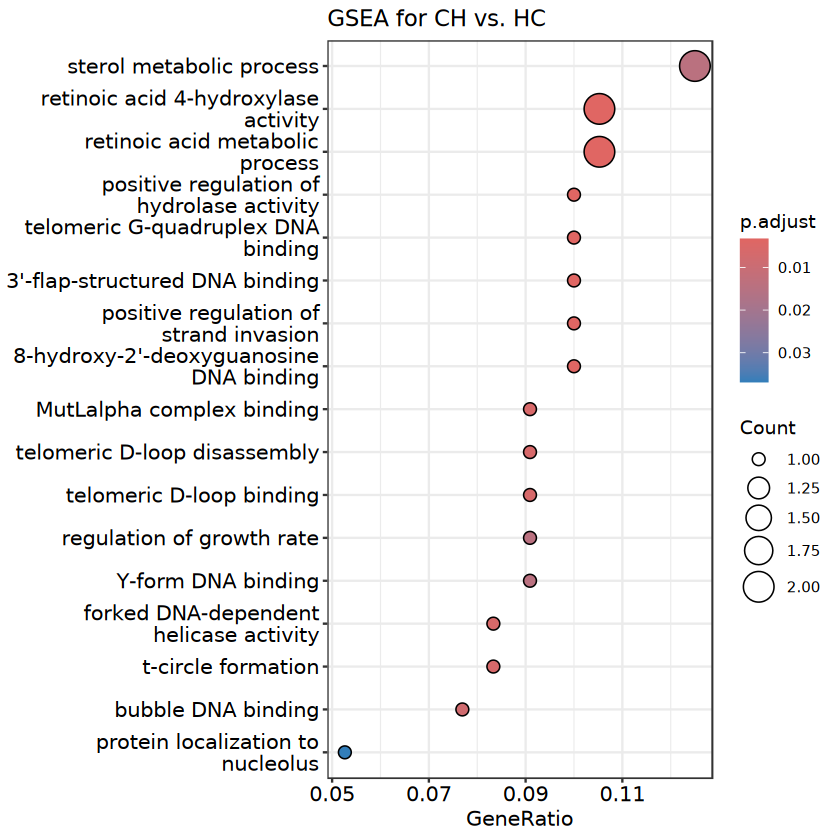

In [21]:
dotplot(gsea_res_ch.hc, showCategory=20) + ggtitle('GSEA for CH vs. HC')

regulation of growth rate is enriched!!

also a lot of D-loop, t-circle, Y-form - I'm assuming these have to do with DNA repair and replication

In [22]:
# CB vs. BC
gsea_res_cb.bc <- GSEA(
    geneList = all_df$cb_bc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
as.data.frame(gsea_res_cb.bc)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.08% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH (no enriched terms)
- CC vs. BB (no enriched terms)

In [23]:
# CC vs. WW
gsea_res_cc.ww <- GSEA(
    geneList = all_df$ww_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cc.ww))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.97% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0061820,GO:0061820,telomeric D-loop disassembly,11,-0.9993434,-1.911425,1.419988e-05,0.01150439,0.01150439,11,"tags=18%, list=0%, signal=18%",LOC111112348/LOC111125439
GO:0061821,GO:0061821,telomeric D-loop binding,11,-0.9993434,-1.911425,1.419988e-05,0.01150439,0.01150439,11,"tags=18%, list=0%, signal=18%",LOC111112348/LOC111125439
GO:0032405,GO:0032405,MutLalpha complex binding,11,-0.9992966,-1.911335,1.550158e-05,0.01150439,0.01150439,11,"tags=18%, list=0%, signal=18%",LOC111112348/LOC111125439
GO:0040009,GO:0040009,regulation of growth rate,11,-0.9992727,-1.911290,1.608106e-05,0.01150439,0.01150439,11,"tags=18%, list=0%, signal=18%",LOC111122273/LOC111125439
GO:0035262,GO:0035262,gonad morphogenesis,10,0.9996451,1.838304,4.761431e-06,0.01150439,0.01150439,4,"tags=10%, list=0%, signal=10%",LOC111109183
GO:0000403,GO:0000403,Y-form DNA binding,11,-0.9990769,-1.910915,3.465032e-05,0.02065737,0.02065737,11,"tags=18%, list=0%, signal=18%",LOC111112348/LOC111125439


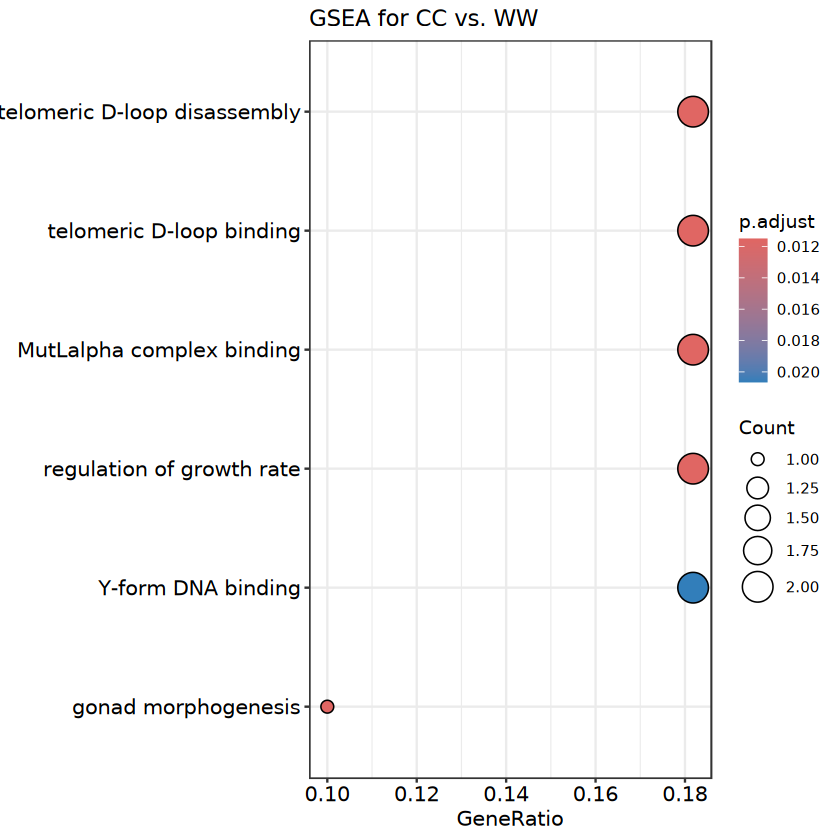

In [24]:
dotplot(gsea_res_cc.ww, showCategory=20) + ggtitle('GSEA for CC vs. WW')

also seeing regulation of growth rate enriched here!

In [25]:
# CC vs. HH
gsea_res_cc.hh <- GSEA(
    geneList = all_df$hh_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cc.hh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [26]:
# CC vs. BB
gsea_res_cc.bb <- GSEA(
    geneList = all_df$bb_cc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cc.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.59% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 5. Effect of initial exposure on response in later exposure

#### A. matched priming
- WW vs. CW
- HH vs. CH
- BB vs. CB

In [27]:
# WW vs. CW
gsea_res_ww.cw <- GSEA(
    geneList = all_df$ww_cw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_ww.cw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0016607,GO:0016607,nuclear speck,279,-0.9976569,-1.248182,7.315218e-06,0.02616654,0.02616654,8,"tags=1%, list=0%, signal=1%",LOC111138453/LOC111125439


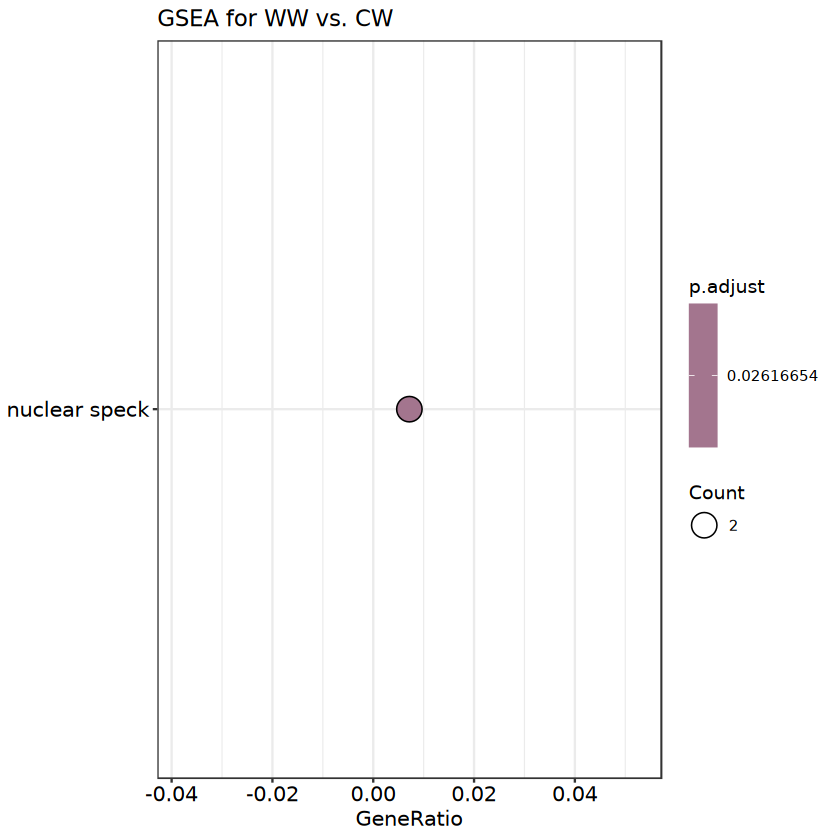

In [28]:
dotplot(gsea_res_ww.cw, showCategory=20) + ggtitle('GSEA for WW vs. CW')

In [29]:
# HH vs. CH
gsea_res_hh.ch <- GSEA(
    geneList = all_df$hh_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hh.ch))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0008401,GO:0008401,retinoic acid 4-hydroxylase activity,19,0.9997828,1.445969,3.011103e-06,0.005385358,0.005385358,3,"tags=5%, list=0%, signal=5%",LOC111100601
GO:0051491,GO:0051491,positive regulation of filopodium assembly,36,-0.9993117,-1.303502,2.382026e-06,0.005385358,0.005385358,11,"tags=6%, list=0%, signal=6%",LOC111107357/LOC111109183
GO:0042573,GO:0042573,retinoic acid metabolic process,19,0.9997710,1.445952,4.707096e-06,0.005612428,0.005612428,3,"tags=5%, list=0%, signal=5%",LOC111100601
GO:0007015,GO:0007015,actin filament organization,92,-0.9971201,-1.216455,7.313995e-06,0.006540540,0.006540540,11,"tags=2%, list=0%, signal=2%",LOC111103378/LOC111109183
GO:0003729,GO:0003729,mRNA binding,150,0.9940773,1.340481,3.893218e-05,0.027852082,0.027852082,58,"tags=1%, list=0%, signal=1%",LOC111134227
GO:0006805,GO:0006805,xenobiotic metabolic process,81,0.9970944,1.323650,6.434320e-05,0.038359273,0.038359273,3,"tags=1%, list=0%, signal=1%",LOC111100601


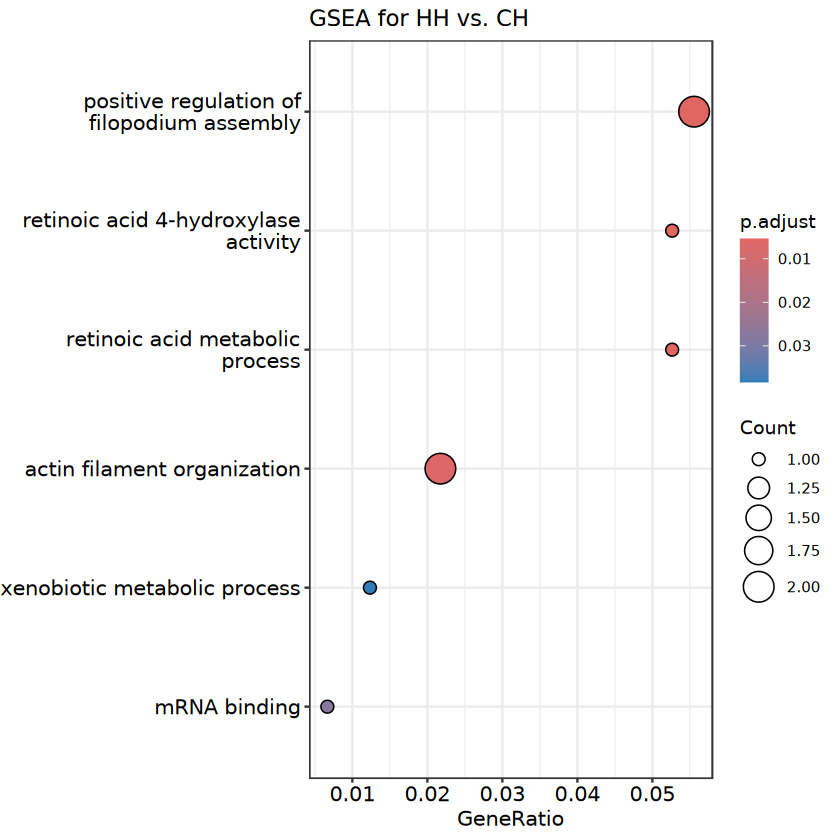

In [30]:
dotplot(gsea_res_hh.ch, showCategory=20) + ggtitle('GSEA for HH vs. CH')

In [33]:
# BB vs. CB
gsea_res_cb.bb <- GSEA(
    geneList = all_df$cb_bb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cb.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.58% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,-0.9991184,-1.323667,5.432478e-06,0.009715987,0.009715987,13,"tags=4%, list=0%, signal=4%",LOC111113608/LOC111109183
GO:0048813,GO:0048813,dendrite morphogenesis,83,-0.9984068,-1.294241,2.916397e-06,0.009715987,0.009715987,13,"tags=2%, list=0%, signal=2%",LOC111113548/LOC111109183


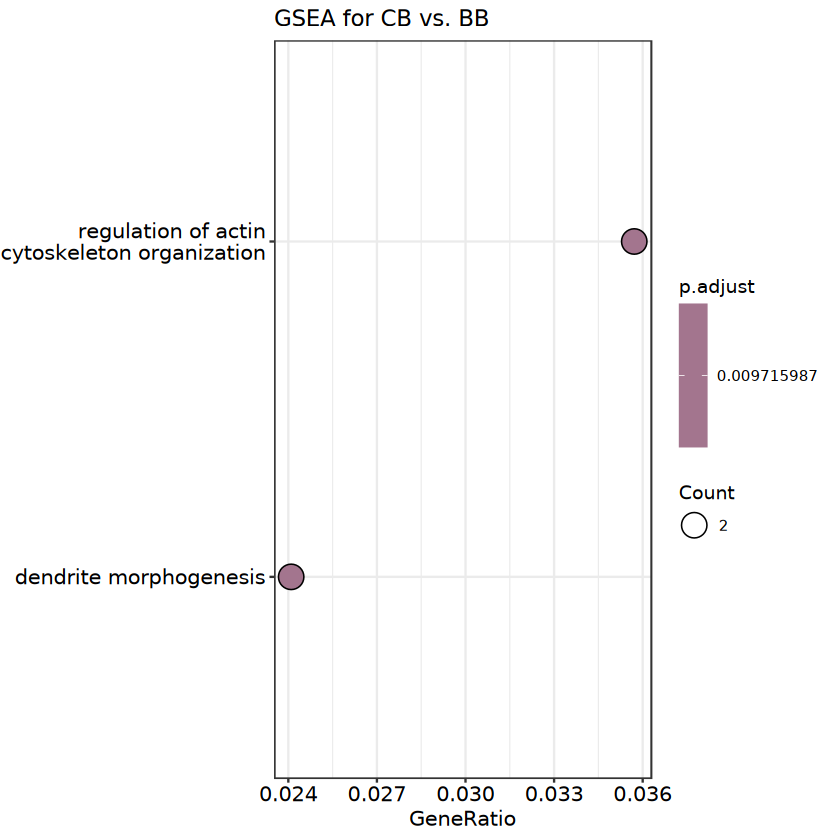

In [34]:
dotplot(gsea_res_cb.bb, showCategory=20) + ggtitle('GSEA for CB vs. BB')

#### B. semi-matched priming: in context of later single stress
- CH vs. BH (no enriched terms)
- CW vs. BW (no enriched terms)

In [35]:
# CH vs. BH
gsea_res_ch.bh <- GSEA(
    geneList = all_df$bh_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_ch.bh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.4% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [36]:
# CW vs. BW
gsea_res_cw.bw <- GSEA(
    geneList = all_df$bw_cw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cw.bw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

#### C. semi-matched priming: in context of later multiple stress
- CB vs. WB
- CB vs. HB

In [37]:
# WB vs. CB
gsea_res_wb.cb <- GSEA(
    geneList = all_df$wb_cb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wb.cb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0032956,GO:0032956,regulation of actin cytoskeleton organization,56,0.9970300,1.323191,4.837138e-07,0.001730244,0.001730244,7,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0017124,GO:0017124,SH3 domain binding,66,0.9950544,1.323283,8.093548e-06,0.014475311,0.014475311,7,"tags=2%, list=0%, signal=2%",LOC111109183
GO:0048813,GO:0048813,dendrite morphogenesis,83,0.9928977,1.311204,2.745393e-05,0.032734242,0.032734242,7,"tags=1%, list=0%, signal=1%",LOC111109183


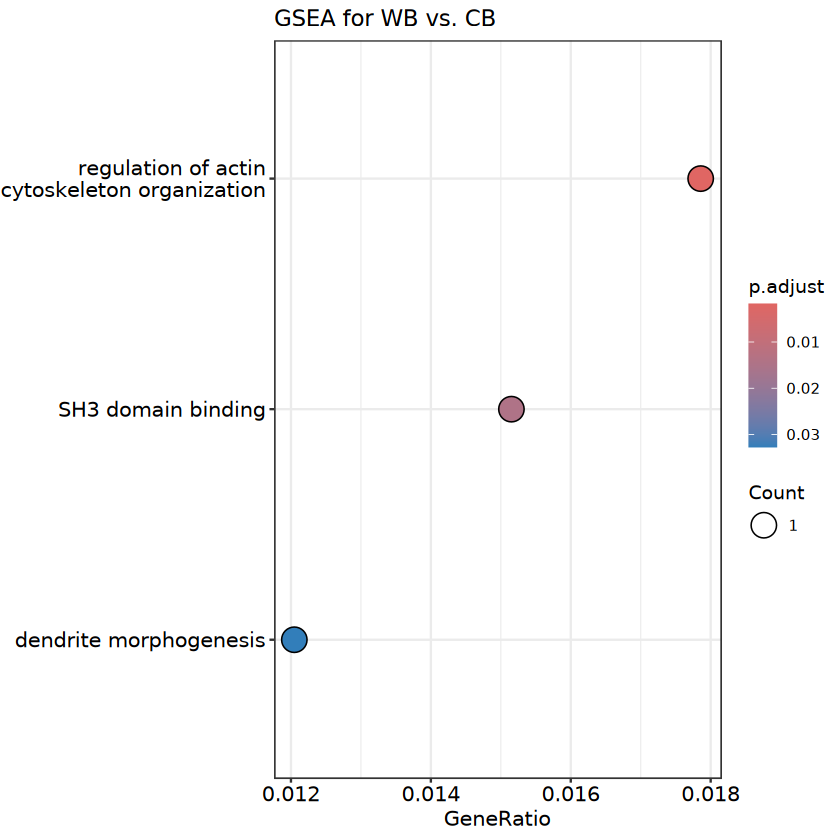

In [38]:
dotplot(gsea_res_wb.cb, showCategory=20) + ggtitle('GSEA for WB vs. CB')

In [39]:
# HB vs. CB
gsea_res_hb.cb <- GSEA(
    geneList = all_df$hb_cb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hb.cb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.94% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0016607,GO:0016607,nuclear speck,279,0.9980782,1.212716,1.658876e-07,0.0005933799,0.0005933799,13,"tags=0%, list=0%, signal=0%",LOC111125439
GO:0010591,GO:0010591,regulation of lamellipodium assembly,12,0.9997063,1.456513,3.095077e-06,0.0055355450,0.0055355450,10,"tags=8%, list=0%, signal=8%",LOC111109183
GO:0090656,GO:0090656,t-circle formation,12,0.9994819,1.456186,7.642562e-06,0.0074701033,0.0074701033,13,"tags=8%, list=0%, signal=8%",LOC111125439
GO:0061749,GO:0061749,forked DNA-dependent helicase activity,12,0.9994517,1.456142,8.353484e-06,0.0074701033,0.0074701033,13,"tags=8%, list=0%, signal=8%",LOC111125439
GO:0030027,GO:0030027,lamellipodium,150,0.9985468,1.228089,1.743897e-05,0.0103965299,0.0103965299,10,"tags=1%, list=0%, signal=1%",LOC111109183
GO:0006974,GO:0006974,DNA damage response,268,0.9970333,1.210913,1.591606e-05,0.0103965299,0.0103965299,13,"tags=0%, list=0%, signal=0%",LOC111125439


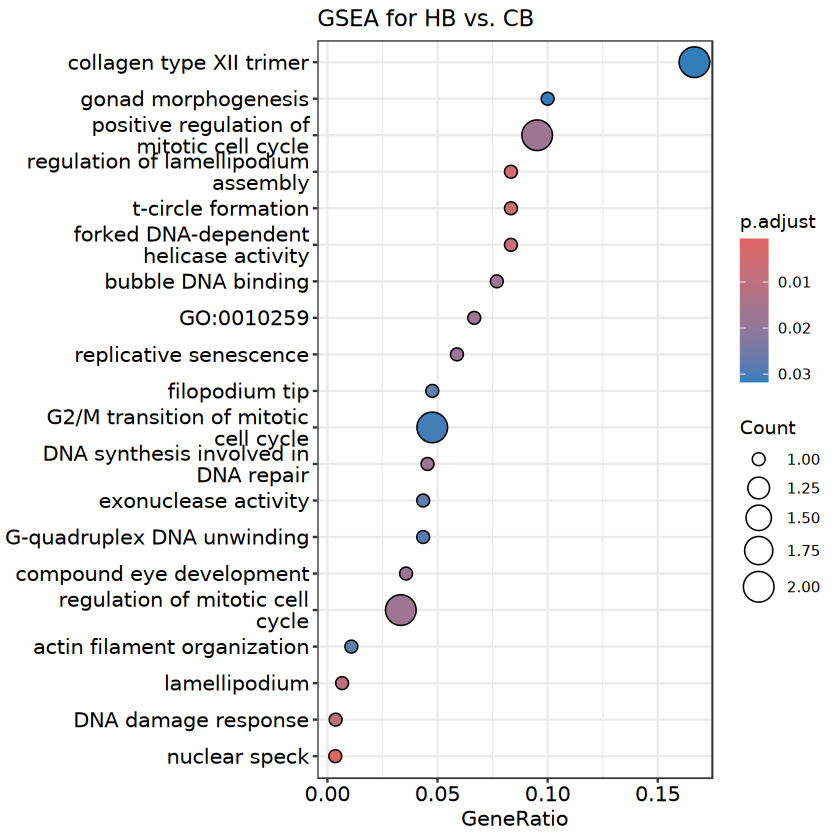

In [40]:
dotplot(gsea_res_hb.cb, showCategory=20) + ggtitle('GSEA for HB vs. CB')

### 6. Effect of initial exposure on subsequent response to stress
- WW vs. WC (no enriched terms)
- HH vs. HC
- BB vs. BC (no enriched terms)

In [41]:
# WW vs. WC
gsea_res_ww.wc <- GSEA(
    geneList = all_df$wc_ww,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_ww.wc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.73% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [42]:
# HH vs. HC
gsea_res_hh.hc <- GSEA(
    geneList = all_df$hc_hh,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hh.hc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.05% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0051345,GO:0051345,positive regulation of hydrolase activity,10,-0.9982811,-1.864363,9.863598e-05,0.03920232,0.03920232,14,"tags=20%, list=0%, signal=20%",LOC111115333/LOC111125439
GO:0061849,GO:0061849,telomeric G-quadruplex DNA binding,10,-0.9982811,-1.864363,9.863598e-05,0.03920232,0.03920232,14,"tags=20%, list=0%, signal=20%",LOC111115333/LOC111125439
GO:0070337,GO:0070337,3'-flap-structured DNA binding,10,-0.9982811,-1.864363,9.863598e-05,0.03920232,0.03920232,14,"tags=20%, list=0%, signal=20%",LOC111115333/LOC111125439
GO:0098530,GO:0098530,positive regulation of strand invasion,10,-0.9982811,-1.864363,9.863598e-05,0.03920232,0.03920232,14,"tags=20%, list=0%, signal=20%",LOC111115333/LOC111125439
GO:1905773,GO:1905773,8-hydroxy-2'-deoxyguanosine DNA binding,10,-0.9982811,-1.864363,9.863598e-05,0.03920232,0.03920232,14,"tags=20%, list=0%, signal=20%",LOC111115333/LOC111125439
GO:0061820,GO:0061820,telomeric D-loop disassembly,11,-0.9981574,-1.862974,5.063953e-05,0.03920232,0.03920232,14,"tags=18%, list=0%, signal=18%",LOC111115333/LOC111125439


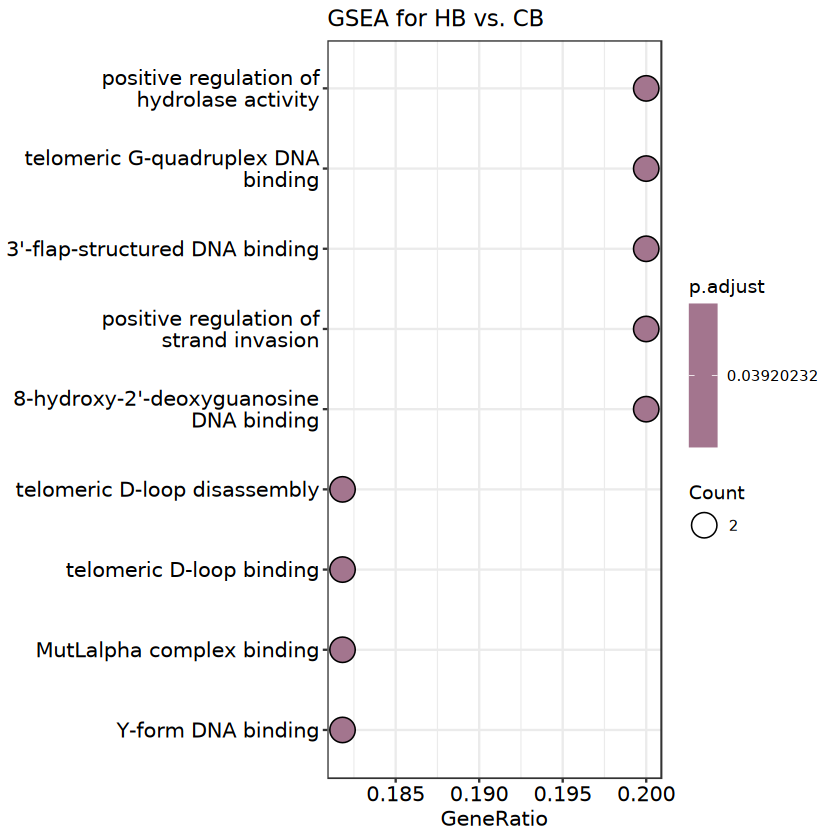

In [59]:
dotplot(gsea_res_hh.hc, showCategory=20) + ggtitle('GSEA for HB vs. CB')

In [43]:
# BB vs. BC
gsea_res_bb.bc <- GSEA(
    geneList = all_df$bc_bb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bb.bc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.6% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 7. Effect of initial single/multiple stress on response in ...

#### 7A. ...later *single* stress
- BH vs. HH
- BW vs. WW

(no enriched terms in these comparisons)

In [44]:
# BH vs. HH
gsea_res_bh.hh <- GSEA(
    geneList = all_df$bh_hh,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bh.hh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.05% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [45]:
# BW vs. WW
gsea_res_bw.ww <- GSEA(
    geneList = all_df$bw_ww,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bw.ww))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.94% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

#### 7B. ...later *multiple* stressors
- HB vs. BB
- WB vs. BB (no enriched terms)

In [46]:
# HB vs. BB
gsea_res_hb.bb <- GSEA(
    geneList = all_df$hb_bb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hb.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.57% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0016567,GO:0016567,protein ubiquitination,332,-0.9928199,-1.259073,2.918166e-06,0.01043828,0.01043828,117,"tags=2%, list=0%, signal=2%",LOC111107718/LOC111109691/LOC111110547/LOC111108308/LOC111107614


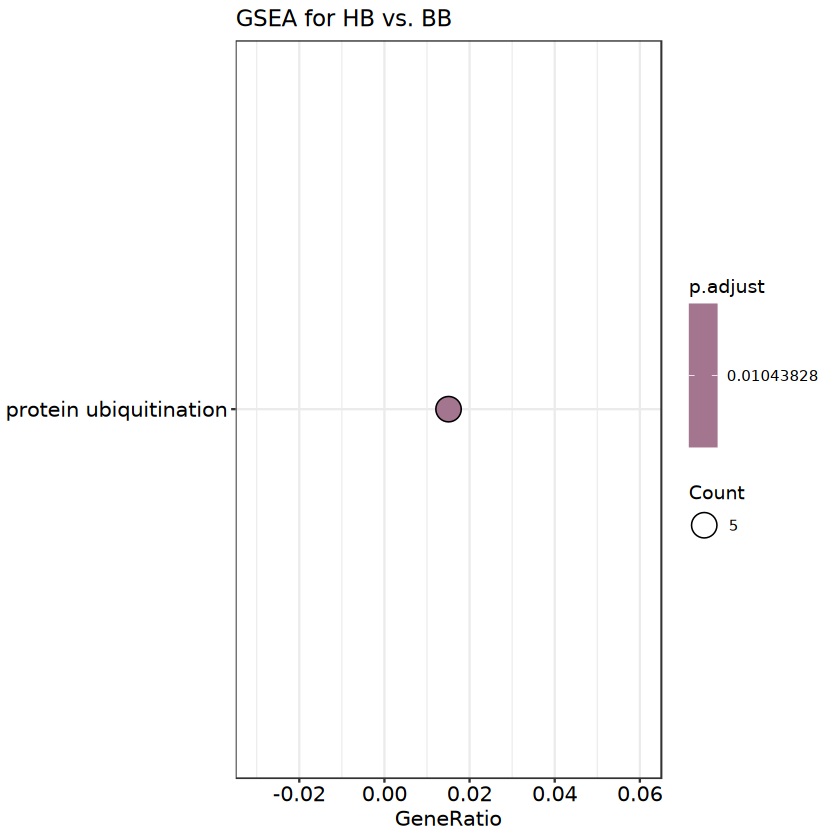

In [47]:
dotplot(gsea_res_hb.bb, showCategory=20) + ggtitle('GSEA for HB vs. BB')

In [48]:
# WB vs. BB
gsea_res_wb.bb <- GSEA(
    geneList = all_df$wb_bb,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wb.bb))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.59% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 8. Shared/unique response among stressors with ...

#### 8A. ...different *early* stressors
- WC vs. HC (no enriched terms)
- BC vs. HC
- BC vs. WC 

In [49]:
# WC vs. HC
gsea_res_wc.hc <- GSEA(
    geneList = all_df$wc_hc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wc.hc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.52% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [50]:
# BC vs. HC
gsea_res_bc.hc <- GSEA(
    geneList = all_df$bc_hc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bc.hc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.05% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0006511,GO:0006511,ubiquitin-dependent protein catabolic process,199,-0.9978323,-1.217356,3.196666e-08,8.719348e-05,8.719348e-05,18,"tags=1%, list=0%, signal=1%",LOC111107216/LOC111103124
GO:0030496,GO:0030496,midbody,139,-0.9986536,-1.195039,4.875230e-08,8.719348e-05,8.719348e-05,18,"tags=1%, list=0%, signal=1%",LOC111100962/LOC111103124
GO:0004843,GO:0004843,cysteine-type deubiquitinase activity,77,-0.9990925,-1.230551,5.099459e-06,5.764322e-03,5.764322e-03,18,"tags=3%, list=0%, signal=3%",LOC111118807/LOC111103124
GO:0014069,GO:0014069,postsynaptic density,213,-0.9959122,-1.210299,6.445984e-06,5.764322e-03,5.764322e-03,18,"tags=1%, list=0%, signal=1%",LOC111114566/LOC111103124
GO:0016579,GO:0016579,protein deubiquitination,63,-0.9991306,-1.248959,2.090954e-05,1.495869e-02,1.495869e-02,18,"tags=3%, list=0%, signal=3%",LOC111118807/LOC111103124
GO:0010468,GO:0010468,regulation of gene expression,130,-0.9970579,-1.197786,4.467896e-05,2.569224e-02,2.569224e-02,35,"tags=2%, list=0%, signal=2%",LOC111110307/LOC111126527


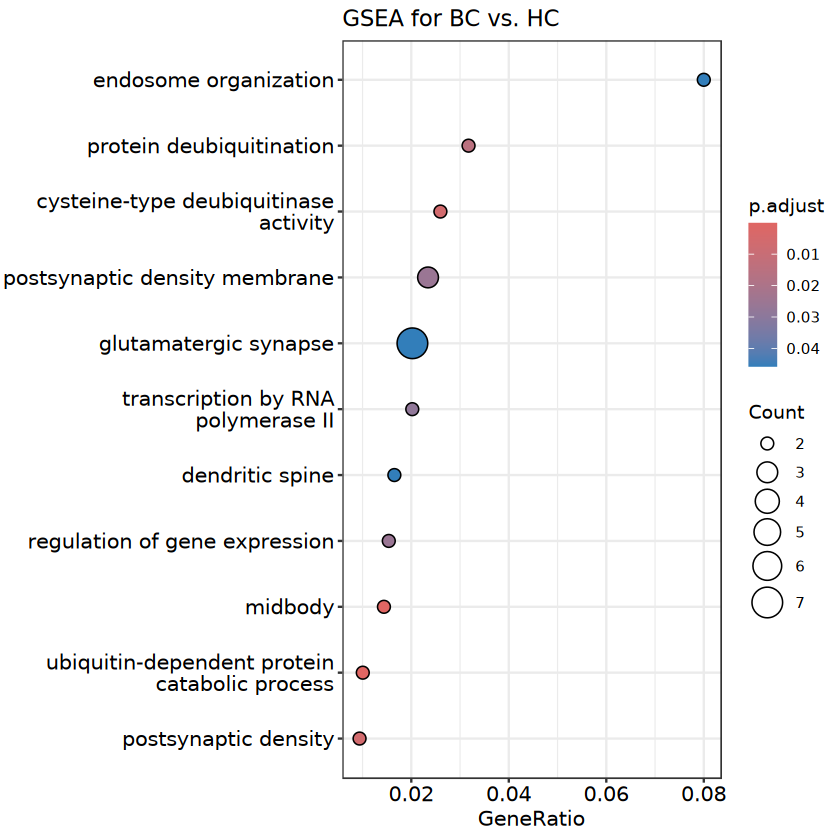

In [51]:
dotplot(gsea_res_bc.hc, showCategory=20) + ggtitle('GSEA for BC vs. HC')

In [52]:
# BC vs. WC
gsea_res_bc.wc <- GSEA(
    geneList = all_df$bc_wc,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_bc.wc))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.09% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0030496,GO:0030496,midbody,139,-0.9974468,-1.188626,1.552151e-07,0.0005552045,0.0005552045,28,"tags=1%, list=0%, signal=1%",LOC111135601/LOC111103124
GO:0006511,GO:0006511,ubiquitin-dependent protein catabolic process,199,-0.9947364,-1.187297,1.125245e-06,0.0020125006,0.0020125006,28,"tags=1%, list=0%, signal=1%",LOC111115555/LOC111103124
GO:0004843,GO:0004843,cysteine-type deubiquitinase activity,77,-0.9980226,-1.219448,4.001948e-05,0.0360309695,0.0360309695,28,"tags=3%, list=0%, signal=3%",LOC111125528/LOC111103124
GO:0006366,GO:0006366,transcription by RNA polymerase II,99,-0.9968451,-1.198169,4.029183e-05,0.0360309695,0.0360309695,44,"tags=2%, list=0%, signal=2%",LOC111137117/LOC111126527
GO:0098978,GO:0098978,glutamatergic synapse,346,-0.9870809,-1.216507,6.672047e-05,0.0477318229,0.0477318229,204,"tags=1%, list=1%, signal=1%",LOC111104095/LOC111123298/LOC111125415/LOC111125416/LOC111103124


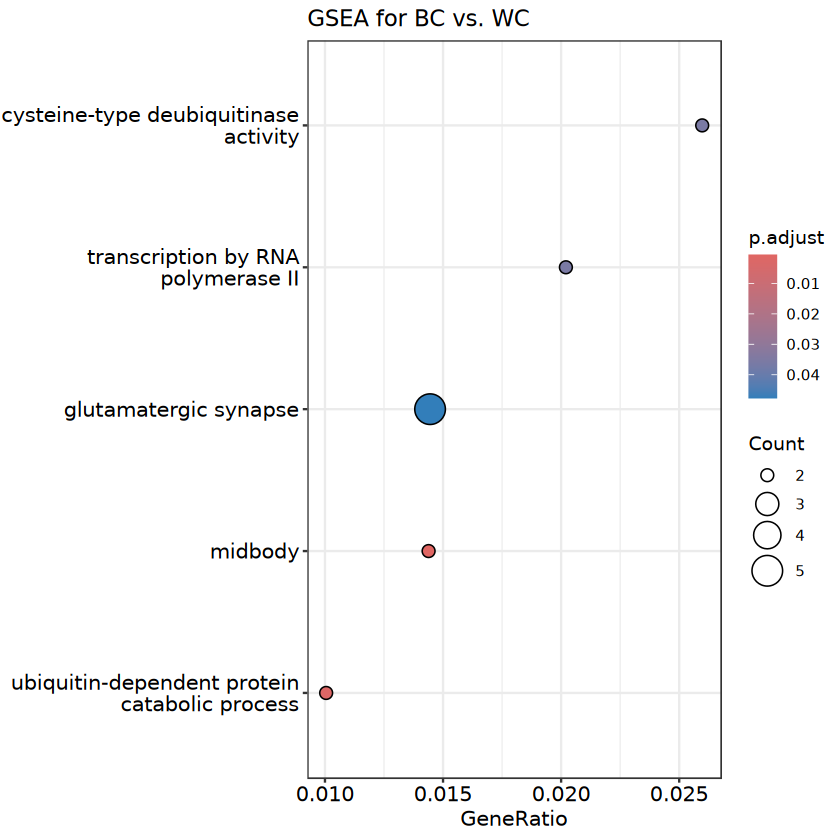

In [61]:
dotplot(gsea_res_bc.wc, showCategory=20) + ggtitle('GSEA for BC vs. WC')

#### 8B. ...different *late* stressors
- CW vs. CH
- CB vs. CH (no enriched terms)
- CB vs. CW (no enriched terms)


In [53]:
# CW vs. CH
gsea_res_cw.ch <- GSEA(
    geneList = all_df$cw_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cw.ch))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.74% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0008401,GO:0008401,retinoic acid 4-hydroxylase activity,19,0.9985725,1.660819,3.379351e-06,0.01208794,0.01208794,2,"tags=5%, list=0%, signal=5%",LOC111100601


no enriched GO terms

In [54]:
# CB vs. CH
gsea_res_cb.ch <- GSEA(
    geneList = all_df$cb_ch,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cb.ch))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.77% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [55]:
# CB vs. CW
gsea_res_cb.cw <- GSEA(
    geneList = all_df$cb_cw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_cb.cw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.97% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

### 9. Effect of order of stressors on GE
- WH vs. HW
- WB vs. BW
- HB vs. BH

(no enriched terms in these comparisons)

In [56]:
# WH vs. HW
gsea_res_wh.hw <- GSEA(
    geneList = all_df$wh_hw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wh.hw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.62% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [57]:
# WB vs. BW
gsea_res_wb.bw <- GSEA(
    geneList = all_df$wb_bw,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_wb.bw))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.95% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms

In [58]:
# HB vs. BH
gsea_res_hb.bh <- GSEA(
    geneList = all_df$hb_bh,
    TERM2GENE = term2gene, 
    TERM2NAME = term2name,
    pvalueCutoff = 0.05)
head(as.data.frame(gsea_res_hb.bh))

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.67% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


no enriched GO terms